In [1]:
import iris.coord_categorisation
import iris
import numpy as np
import os
import geopandas as gpd
import sys
import matplotlib 
import numpy.ma as ma
import warnings
import iris.quickplot as qplt
import iris.plot as iplt
import cartopy.crs as ccrs
from matplotlib import colors
import glob as glob
import datetime
warnings.simplefilter(action = 'ignore', category = FutureWarning)

# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, '/nfs/a319/gy17m2a/PhD/Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

trim_to_leeds = False

# Constraint to only load JJA data
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

##################################################################
# Load necessary spatial data
##################################################################
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
uk_gdf = create_uk_outline({'init' :'epsg:3857'})


In [3]:
resolution = '1km'
years= range(1990,2015)
year =1990

# Create directory to store outputs in
if resolution =='1km':
    ddir = f"ProcessedData/TimeSeries/CEH-GEAR/{resolution}/"
else:
    ddir = f"ProcessedData/TimeSeries/CEH-GEAR/{resolution}/NearestNeighbour/"
if not os.path.isdir(ddir):
    os.makedirs(ddir)

filenames =[]
# Create filepath to correct folder using correct resolution
if resolution == '1km': 
    general_filename = f'datadir/CEH-GEAR/CEH-GEAR_reformatted/rf_CEH-GEAR-1hr_{year}*'   
elif resolution == '2.2km':
    general_filename = f'datadir/CEH-GEAR/CEH-GEAR_regridded_2.2km/NearestNeighbour/rg_CEH-GEAR-1hr_{year}*'
elif resolution == '12km':
    general_filename = f'datadir/CEH-GEAR/CEH-GEAR_regridded_12km/NearestNeighbour/rg_CEH-GEAR-1hr_{year}*'
print(general_filename)

# Find all files in directory which start with this string
for filename in glob.glob(general_filename):
    filenames.append(filename)
print(len(filenames))

monthly_cubes_list = iris.load(filenames, in_jja)    
#print(monthly_cubes_list)

# Concatenate the cubes into one
print('Concatenating cube')
obs_cube = monthly_cubes_list.concatenate_cube()     
#print(obs_cube) 

datadir/CEH-GEAR/CEH-GEAR_reformatted/rf_CEH-GEAR-1hr_1990*
12
Concatenating cube


In [55]:
resolution = '1km'
years= range(1990,2015)
for year in years:

    # Create directory to store outputs in
    if resolution =='1km':
        ddir = f"ProcessedData/TimeSeries/CEH-GEAR/{resolution}/"
    else:
        ddir = f"ProcessedData/TimeSeries/CEH-GEAR/{resolution}/NearestNeighbour/"
    if not os.path.isdir(ddir):
        os.makedirs(ddir)

    filenames =[]
    # Create filepath to correct folder using correct resolution
    if resolution == '1km': 
        general_filename = f'datadir/CEH-GEAR/CEH-GEAR_reformatted/rf_CEH-GEAR-1hr_{year}*'   
    elif resolution == '2.2km':
        general_filename = f'datadir/CEH-GEAR/CEH-GEAR_regridded_2.2km/NearestNeighbour/rg_CEH-GEAR-1hr_{year}*'
    elif resolution == '12km':
        general_filename = f'datadir/CEH-GEAR/CEH-GEAR_regridded_12km/NearestNeighbour/rg_CEH-GEAR-1hr_{year}*'
    print(general_filename)

    # Find all files in directory which start with this string
    for filename in glob.glob(general_filename):
        filenames.append(filename)
    print(len(filenames))

    monthly_cubes_list = iris.load(filenames, in_jja)    
    #print(monthly_cubes_list)

    # Concatenate the cubes into one
    print('Concatenating cube')
    obs_cube = monthly_cubes_list.concatenate_cube()     
    #print(obs_cube) 
    
    ################################################################
    ### Cut the cube to the extent of GDF surrounding UK  
    ################################################################
    obs_cube = trim_to_bbox_of_region_obs(obs_cube, uk_gdf)
    
    ################################################################
    # Cut the cube to the extent of GDF surrounding Leeds  
    ################################################################
    print('trimming cube')
    if trim_to_leeds == True:
        if resolution == '2.2km':
            obs_cube = trim_to_bbox_of_region_regriddedobs(obs_cube, leeds_at_centre_gdf)
        else:
              obs_cube = trim_to_bbox_of_region_obs(obs_cube, leeds_at_centre_gdf)
    else:
        if resolution == '2.2km':
            obs_cube = trim_to_bbox_of_region_regriddedobs(obs_cube, uk_gdf)
        else:
            obs_cube = trim_to_bbox_of_region_obs(obs_cube, uk_gdf)
            
    ################################################################
    ###  Get mask and regrid to the obs cube
    ################################################################
    print("getting mask")
    lsm_cubes_list = iris.load("/nfs/a319/gy17m2a/PhD/datadir/lsm_land-cpm_BI_5km.nc")
    lsm = lsm_cubes_list[0]
    lsm_nn =lsm.regrid(obs_cube,iris.analysis.Nearest())  
    
    # Convert to shape of cube
    broadcasted_lsm_data = np.broadcast_to(lsm_nn.data.data, obs_cube.shape)
    # Convert to integer
    broadcasted_lsm_data_int = broadcasted_lsm_data.astype(int)
    # Reverse the array (it is the opposite way round to the exisitng val/no val mask on the radar data)
    reversed_array = ~broadcasted_lsm_data_int.astype(bool)  
    
    ### Mask the cube using the lsm cube
    masked_cube = iris.util.mask_cube(obs_cube, reversed_array)
    
    ### Compress data (flatten and remove masked values)
    compressed = masked_cube.data.compressed()
    compressed.shape[0]
    print(len(compressed))
    print(f"min value is: {np.nanmin(compressed)}")
    print(f"max value is: {np.nanmax(compressed)}")
    print(f"mean value is: {np.nanmean(compressed)}")
    
    # Save to file
    np.save(ddir + f'{year}_compressed.npy', compressed) 

datadir/CEH-GEAR/CEH-GEAR_reformatted/rf_CEH-GEAR-1hr_1990*
12
Concatenating cube
trimming cube
getting mask
656537760
min value is: 0.0
max value is: 76.80000305175781
mean value is: 0.09506487101316452
datadir/CEH-GEAR/CEH-GEAR_reformatted/rf_CEH-GEAR-1hr_1991*
12
Concatenating cube
trimming cube
getting mask
656537760
min value is: 0.0
max value is: 44.599998474121094
mean value is: 0.09976404160261154
datadir/CEH-GEAR/CEH-GEAR_reformatted/rf_CEH-GEAR-1hr_1992*
12
Concatenating cube
trimming cube
getting mask
656537760
min value is: 0.0
max value is: 125.9000015258789
mean value is: 0.12749764323234558
datadir/CEH-GEAR/CEH-GEAR_reformatted/rf_CEH-GEAR-1hr_1993*
12
Concatenating cube
trimming cube
getting mask
656537760
min value is: 0.0
max value is: 72.69999694824219
mean value is: 0.0999448299407959
datadir/CEH-GEAR/CEH-GEAR_reformatted/rf_CEH-GEAR-1hr_1994*
12
Concatenating cube
trimming cube
getting mask
656537760
min value is: 0.0
max value is: 57.400001525878906
mean value is:

In [47]:
########
# Get the times
########
# Step 2: Get the indices of the non-masked values in the original data
non_masked_indices = np.where(~masked_cube.data.mask)

# Step 3: Extract corresponding time values
time_values = masked_cube.coord('time').points[non_masked_indices[0]]
# np.save(ddir + f'{year}_timevalues.npy', time_values) 
time_values

array([6.441984e+08, 6.441984e+08, 6.441984e+08, ..., 6.521436e+08,
       6.521436e+08, 6.521436e+08])

In [51]:
test_time = time_values[:10]

In [53]:
# ################################################################  
# times = obs_cube.coord('time').points
# # Convert to datetimes
times = [datetime.datetime.fromtimestamp(x).strftime("%x %X") for x in test_time]
times= [datetime.datetime.strptime(x, '%m/%d/%y %H:%M:%S') for x in times]
times
# # Convert to datetime - doesnt work due to 30 days in Feb
# np.save(f"ProcessedData/TimeSeries/CEH-GEAR/{resolution}/timestamps.npy", times) 

[datetime.datetime(1990, 6, 1, 1, 0),
 datetime.datetime(1990, 6, 1, 1, 0),
 datetime.datetime(1990, 6, 1, 1, 0),
 datetime.datetime(1990, 6, 1, 1, 0),
 datetime.datetime(1990, 6, 1, 1, 0),
 datetime.datetime(1990, 6, 1, 1, 0),
 datetime.datetime(1990, 6, 1, 1, 0),
 datetime.datetime(1990, 6, 1, 1, 0),
 datetime.datetime(1990, 6, 1, 1, 0),
 datetime.datetime(1990, 6, 1, 1, 0)]

### Check plotting

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


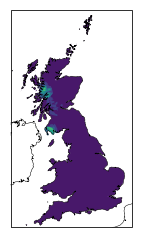

In [10]:
obs_cube = monthly_cubes_list.concatenate_cube()  
iplt.contourf(obs_cube[0])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [5]:
# ################################################################
# # Once across all ensemble members, save a numpy array storing
# # the timestamps to which the data refer
# ################################################################  
# times = obs_cube.coord('time').points
# # Convert to datetimes
# times = [datetime.datetime.fromtimestamp(x).strftime("%x %X") for x in times]
# times= [datetime.datetime.strptime(x, '%m/%d/%y %H:%M:%S') for x in times]

# # Convert to datetime - doesnt work due to 30 days in Feb
# np.save(f"ProcessedData/TimeSeries/CEH-GEAR/{resolution}/timestamps.npy", times) 

In [29]:
masked_cube = iris.util.mask_cube(obs_cube, reversed_array)

### Check plotting

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


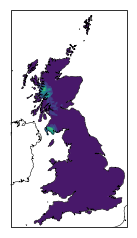

In [30]:
iplt.contourf(masked_cube[0])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [31]:
compressed = masked_cube.data.compressed()
compressed.shape[0]

656537760

In [45]:
compressed_nonan = compressed[~np.isnan(compressed)]
len(compressed_nonan)

516243648

In [44]:
# flat = obs_cube.data.flatten()
flat_nonan = flat[~np.isnan(flat)]
len(flat)
len(flat_nonan)

# 1853441568
# 656537760
# 521955744
# 516243648

521955744

### Sense check min/max values

In [36]:
print(np.nanmin(compressed))
print(np.nanmax(compressed))
print(np.nanmean(compressed))

0.0
76.8
0.09506487


In [37]:
print(np.nanmin(flat))
print(np.nanmax(flat))
print(np.nanmean(flat))

0.0
76.8
0.09506425


### Save to numpy array

In [ ]:
np.save(ddir + f'{year}_compressed.npy', compressed) 

In [16]:
# obs_cube_uk  = trim_to_bbox_of_region_obs(obs_cube, uk_gdf)
# obs_cube_uk

In [8]:
# test = obs_cube[:10000, :, :]

In [17]:
# compressed = masked_cube.data.compressed()
# compressed.shape[0]